# Sharadar Data Explorer

This notebook helps you explore the Sharadar bundle data:
1. **Database Summary** - Overview of available data
2. **Price Data** - Explore OHLCV pricing for specific symbols
3. **Fundamentals Data** - Explore SF1 fundamentals for specific symbols
4. **Field Availability** - See which fields have data
5. **Symbol Lookup** - Find SIDs and date ranges for symbols

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Register bundle
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register('sharadar', sharadar_bundle(tickers=None, incremental=True, include_funds=True))

# Load bundle
from zipline.data.bundles import load as load_bundle
bundle_data = load_bundle('sharadar')

print("✓ Sharadar bundle loaded successfully")
print(f"Bundle path: {Path(bundle_data.equity_daily_bar_reader._table.rootdir).parent.parent}")

✓ Sharadar bundle loaded successfully
Bundle path: /root/.zipline/data/sharadar


## 1. Database Summary

In [2]:
# Get all assets
all_assets = bundle_data.asset_finder.retrieve_all(bundle_data.asset_finder.sids)

print("="*80)
print("SHARADAR BUNDLE SUMMARY")
print("="*80)
print(f"\nTotal Assets: {len(all_assets):,}")

# Date range
start_dates = [asset.start_date for asset in all_assets if asset.start_date]
end_dates = [asset.end_date for asset in all_assets if asset.end_date]

if start_dates and end_dates:
    print(f"Date Range: {min(start_dates).date()} to {max(end_dates).date()}")
    print(f"  Earliest data: {min(start_dates).date()}")
    print(f"  Latest data: {max(end_dates).date()}")

# Asset types
asset_types = {}
for asset in all_assets:
    asset_type = getattr(asset, 'asset_type', 'equity')
    asset_types[asset_type] = asset_types.get(asset_type, 0) + 1

print(f"\nAsset Types:")
for asset_type, count in sorted(asset_types.items()):
    print(f"  {asset_type}: {count:,}")

# Sample assets
print(f"\nSample Assets:")
for asset in list(all_assets)[:10]:
    print(f"  {asset.symbol:8s} SID: {asset.sid:6d}  {asset.start_date.date()} to {asset.end_date.date()}")

SHARADAR BUNDLE SUMMARY

Total Assets: 30,701
Date Range: 1998-01-02 to 2025-11-17
  Earliest data: 1998-01-02
  Latest data: 2025-11-17

Asset Types:
  equity: 30,701

Sample Assets:
  VIG1     SID: 100521  1998-01-02 to 2005-08-25
  DIV1     SID: 100811  1998-01-02 to 2007-10-10
  IGF1     SID: 100819  1998-01-02 to 2003-05-22
  DSI1     SID: 101243  1998-01-02 to 2000-10-20
  PGF1     SID: 101259  1998-01-02 to 2004-06-25
  TUXS     SID: 101286  1998-01-02 to 2007-03-08
  FXBY     SID: 101361  1999-10-26 to 2021-05-26
  PRVW     SID: 101460  1999-12-08 to 2001-07-25
  CYRS1    SID: 101470  2000-01-26 to 2000-09-07
  NWGN1    SID: 101484  1999-05-21 to 2000-12-20


## 2. Symbol Lookup and Info

In [3]:
def get_asset_info(symbol, as_of_date=None):
    """Get detailed information about a symbol."""
    try:
        asset = bundle_data.asset_finder.lookup_symbol(symbol, as_of_date=as_of_date)
        
        print("="*80)
        print(f"ASSET INFO: {symbol}")
        print("="*80)
        print(f"Symbol: {asset.symbol}")
        print(f"SID: {asset.sid}")
        print(f"Asset Name: {asset.asset_name}")
        print(f"Exchange: {asset.exchange}")
        print(f"Start Date: {asset.start_date.date()}")
        print(f"End Date: {asset.end_date.date()}")
        print(f"Asset Type: {getattr(asset, 'asset_type', 'equity')}")
        
        return asset
    except Exception as e:
        print(f"❌ Error looking up {symbol}: {e}")
        return None

# Example: Look up AAPL
aapl = get_asset_info('AAPL')

ASSET INFO: AAPL
Symbol: AAPL
SID: 199059
Asset Name: AAPL
Exchange: NASDAQ
Start Date: 1998-01-02
End Date: 2025-11-17
Asset Type: equity


In [4]:
# Look up multiple symbols
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA']

print("="*80)
print("SYMBOL LOOKUP TABLE")
print("="*80)
print(f"{'Symbol':<10} {'SID':<8} {'Start Date':<12} {'End Date':<12} {'Days':<8}")
print("-"*80)

asset_map = {}
for symbol in symbols:
    try:
        asset = bundle_data.asset_finder.lookup_symbol(symbol, as_of_date=None)
        asset_map[symbol] = asset
        days = (asset.end_date - asset.start_date).days
        print(f"{asset.symbol:<10} {asset.sid:<8} {asset.start_date.date()} {asset.end_date.date()} {days:<8,}")
    except Exception as e:
        print(f"{symbol:<10} Not found: {e}")

SYMBOL LOOKUP TABLE
Symbol     SID      Start Date   End Date     Days    
--------------------------------------------------------------------------------
AAPL       199059   1998-01-02 2025-11-17 10,181  
MSFT       198508   1998-01-02 2025-11-17 10,181  
GOOGL      195146   2004-08-19 2025-11-17 7,760   
AMZN       197029   1998-01-02 2025-11-17 10,181  
TSLA       194897   2010-06-29 2025-11-17 5,620   
META       194817   2012-05-18 2025-11-17 4,931   
NVDA       196754   1999-01-22 2025-11-17 9,796   


## 3. Price Data Explorer

In [5]:
def get_price_data(symbol, start_date=None, end_date=None):
    """Get OHLCV price data for a symbol."""
    try:
        # Look up asset
        asset = bundle_data.asset_finder.lookup_symbol(symbol, as_of_date=None)
        
        # Get sessions (trading days) - these are tz-naive
        sessions = bundle_data.equity_daily_bar_reader.sessions
        
        # Default dates
        if start_date is None:
            start_date = asset.start_date
        else:
            start_date = pd.Timestamp(start_date)
        
        if end_date is None:
            end_date = asset.end_date
        else:
            end_date = pd.Timestamp(end_date)
        
        # Remove timezone for comparison with tz-naive sessions
        if start_date.tz is not None:
            start_date = start_date.tz_localize(None)
        if end_date.tz is not None:
            end_date = end_date.tz_localize(None)
        
        # Filter sessions by date range
        date_range = sessions[(sessions >= start_date) & (sessions <= end_date)]
        
        if len(date_range) == 0:
            print(f"⚠️  No data available for {symbol} in date range")
            return None
        
        # Load data - note: parameter is 'assets' not 'sids'
        data = bundle_data.equity_daily_bar_reader.load_raw_arrays(
            columns=['open', 'high', 'low', 'close', 'volume'],
            start_date=date_range[0],
            end_date=date_range[-1],
            assets=[asset.sid],
        )
        
        # Create DataFrame
        df = pd.DataFrame({
            'open': data[0][:, 0],
            'high': data[1][:, 0],
            'low': data[2][:, 0],
            'close': data[3][:, 0],
            'volume': data[4][:, 0],
        }, index=date_range)
        
        # Remove rows with NaN (no data)
        df = df.dropna()
        
        print(f"✓ Loaded {len(df):,} days of price data for {symbol}")
        print(f"  Date range: {df.index[0].date()} to {df.index[-1].date()}")
        
        return df
    
    except Exception as e:
        print(f"❌ Error loading price data for {symbol}: {e}")
        import traceback
        traceback.print_exc()
        return None

# Example: Get AAPL price data for 2023
aapl_prices = get_price_data('AAPL', '2023-01-01', '2023-12-31')

if aapl_prices is not None:
    print("\nSample data:")
    print(aapl_prices.head(10))

✓ Loaded 250 days of price data for AAPL
  Date range: 2023-01-03 to 2023-12-29

Sample data:
               open     high     low    close     volume
2023-01-03  130.280  130.900  124.17  123.224  111896000
2023-01-04  126.890  128.656  125.08  124.495   88452000
2023-01-05  127.130  127.770  124.76  123.175   79945000
2023-01-06  126.010  130.290  124.89  127.707   86819000
2023-01-09  130.465  133.410  129.89  128.229   70497000
2023-01-10  130.260  131.264  128.12  128.800   63428000
2023-01-11  131.250  133.510  130.46  131.520   69114000
2023-01-12  133.880  134.260  131.44  131.441   71248000
2023-01-13  132.030  134.920  131.66  132.771   57619000
2023-01-17  134.830  137.290  134.13  133.933   63413000


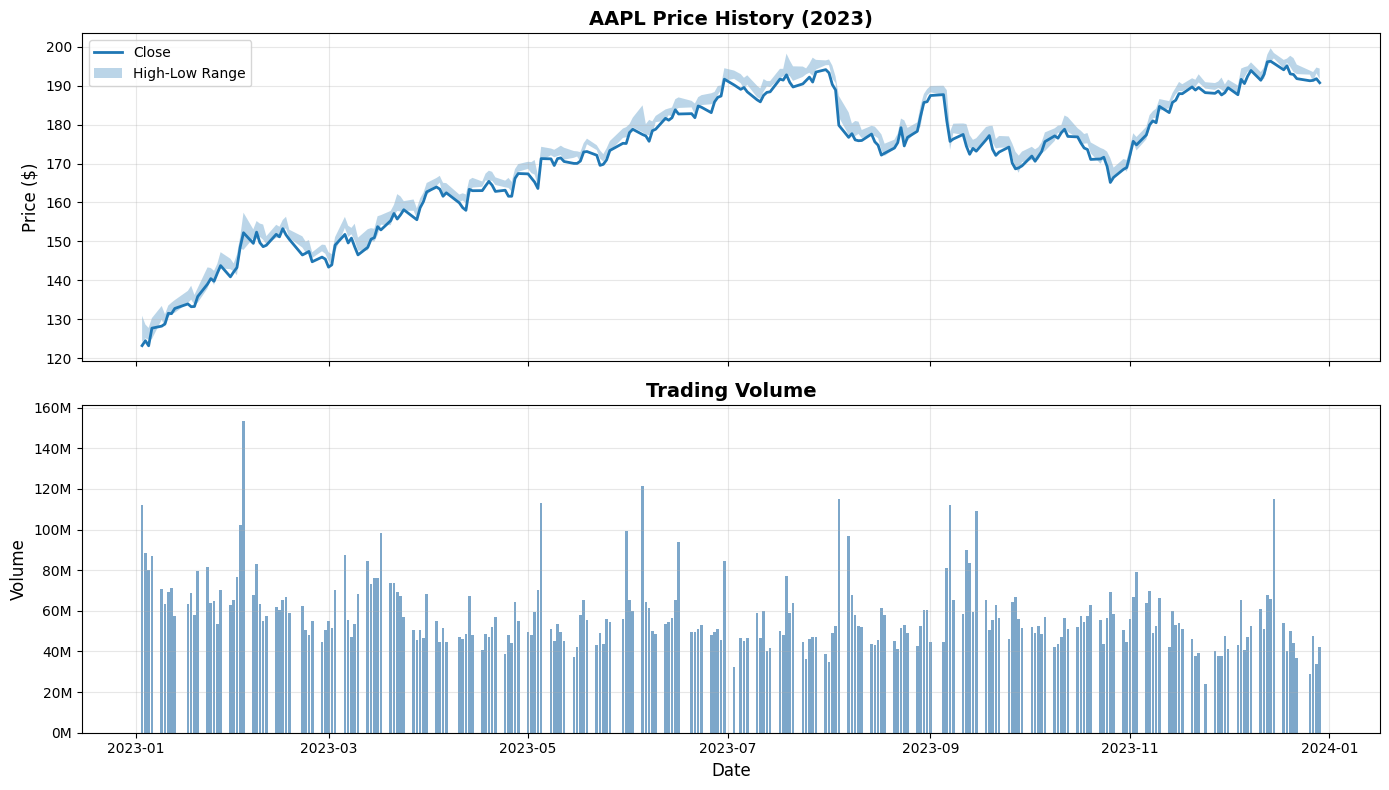


PRICE STATISTICS (2023)
             open        high         low       close        volume
count  250.000000  250.000000  250.000000  250.000000  2.500000e+02
mean   172.246400  173.857176  170.981600  170.527844  5.814008e+07
std     17.528769   17.261072   17.535007   17.341604  1.726345e+07
min    126.010000  127.770000  124.170000  123.175000  2.404300e+07
25%    161.555000  162.387500  160.700250  159.963250  4.710875e+07
50%    175.125000  177.024500  173.840000  173.623000  5.436650e+07
75%    186.805000  188.095000  185.175000  185.446750  6.498900e+07
max    198.020000  199.620000  197.000000  196.272000  1.534570e+08


In [6]:
# Plot price data
if aapl_prices is not None and len(aapl_prices) > 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Price
    ax1.plot(aapl_prices.index, aapl_prices['close'], label='Close', linewidth=2)
    ax1.fill_between(aapl_prices.index, aapl_prices['low'], aapl_prices['high'], alpha=0.3, label='High-Low Range')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.set_title('AAPL Price History (2023)', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Volume
    ax2.bar(aapl_prices.index, aapl_prices['volume'], alpha=0.7, color='steelblue')
    ax2.set_ylabel('Volume', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_title('Trading Volume', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("\n" + "="*80)
    print("PRICE STATISTICS (2023)")
    print("="*80)
    print(aapl_prices.describe())

## 4. Fundamentals Data Explorer

Explore the SF1 fundamentals data (if available).

In [7]:
# Check if fundamentals file exists
# Get bundle directory from the bcolz table rootdir
# rootdir is like: /root/.zipline/data/sharadar/2025-11-18T06;12;45.972010/daily_equities.bcolz
# We need to go up to the bundle directory (2 levels up from daily_equities.bcolz)
bundle_path = Path(bundle_data.equity_daily_bar_reader._table.rootdir).parent
sf1_path = bundle_path / 'fundamentals' / 'sf1.h5'

print(f"Checking for fundamentals data...")
print(f"Bundle path: {bundle_path}")
print(f"SF1 path: {sf1_path}")
print(f"Exists: {sf1_path.exists()}")

if sf1_path.exists():
    print(f"File size: {sf1_path.stat().st_size / 1024 / 1024:.2f} MB")
    FUNDAMENTALS_AVAILABLE = True
else:
    print("⚠️  Fundamentals not available. Run ingest with include_fundamentals=True")
    FUNDAMENTALS_AVAILABLE = False

Checking for fundamentals data...
Bundle path: /root/.zipline/data/sharadar/2025-11-18T06;12;45.972010
SF1 path: /root/.zipline/data/sharadar/2025-11-18T06;12;45.972010/fundamentals/sf1.h5
Exists: True
File size: 187.76 MB


In [8]:
if FUNDAMENTALS_AVAILABLE:
    # Load fundamentals data
    with pd.HDFStore(sf1_path, 'r') as store:
        print("\nHDF5 Keys:")
        for key in store.keys():
            print(f"  {key}")
        
        # Load the main table
        sf1 = store['sf1']
        
        print(f"\n✓ Loaded SF1 fundamentals")
        print(f"  Shape: {sf1.shape}")
        print(f"  Columns: {len(sf1.columns)}")
        print(f"\nFirst few columns: {list(sf1.columns)[:20]}")


HDF5 Keys:
  /sf1

✓ Loaded SF1 fundamentals
  Shape: (635441, 114)
  Columns: 114

First few columns: ['ticker', 'dimension', 'calendardate', 'datekey', 'reportperiod', 'fiscalperiod', 'lastupdated', 'accoci', 'assets', 'assetsavg', 'assetsc', 'assetsnc', 'assetturnover', 'bvps', 'capex', 'cashneq', 'cashnequsd', 'cor', 'consolinc', 'currentratio']


In [9]:
if FUNDAMENTALS_AVAILABLE:
    def get_fundamentals(symbol, field='revenue'):
        """Get fundamentals data for a specific symbol and field."""
        # Look up SID
        asset = bundle_data.asset_finder.lookup_symbol(symbol, as_of_date=None)
        
        # Filter for this SID
        data = sf1[sf1['sid'] == asset.sid].copy()
        
        if len(data) == 0:
            print(f"⚠️  No fundamentals data for {symbol} (SID {asset.sid})")
            return None
        
        # Convert dates
        data['calendardate'] = pd.to_datetime(data['calendardate'])
        data = data.sort_values('calendardate')
        
        print(f"✓ Found {len(data):,} fundamental records for {symbol}")
        print(f"  Date range: {data['calendardate'].min().date()} to {data['calendardate'].max().date()}")
        print(f"  Dimensions: {data['dimension'].unique()}")
        
        return data
    
    # Example: Get AAPL fundamentals
    aapl_fund = get_fundamentals('AAPL')
    
    if aapl_fund is not None:
        print("\nSample records:")
        print(aapl_fund[['calendardate', 'dimension', 'revenue', 'netinc', 'fcf', 'equity', 'debt']].tail(10))

✓ Found 110 fundamental records for AAPL
  Date range: 1998-03-31 to 2025-09-30
  Dimensions: ['ARQ']

Sample records:
        calendardate dimension       revenue        netinc           fcf  \
2088194   2023-06-30       ARQ  8.179700e+10  1.988100e+10  2.428700e+10   
2088195   2023-09-30       ARQ  8.949800e+10  2.295600e+10  1.943500e+10   
2088196   2023-12-31       ARQ  1.195750e+11  3.391600e+10  3.750300e+10   
2088197   2024-03-31       ARQ  9.075300e+10  2.363600e+10  2.069400e+10   
2088198   2024-06-30       ARQ  8.577700e+10  2.144800e+10  2.670700e+10   
2088199   2024-09-30       ARQ  9.493000e+10  1.473600e+10  2.390300e+10   
2088201   2024-12-31       ARQ  1.243000e+11  3.633000e+10  2.699500e+10   
2088202   2025-03-31       ARQ  9.535900e+10  2.478000e+10  2.088100e+10   
2088203   2025-06-30       ARQ  9.403600e+10  2.343400e+10  2.440500e+10   
2088204   2025-09-30       ARQ  1.024660e+11  2.746600e+10  2.648600e+10   

               equity          debt  
208819

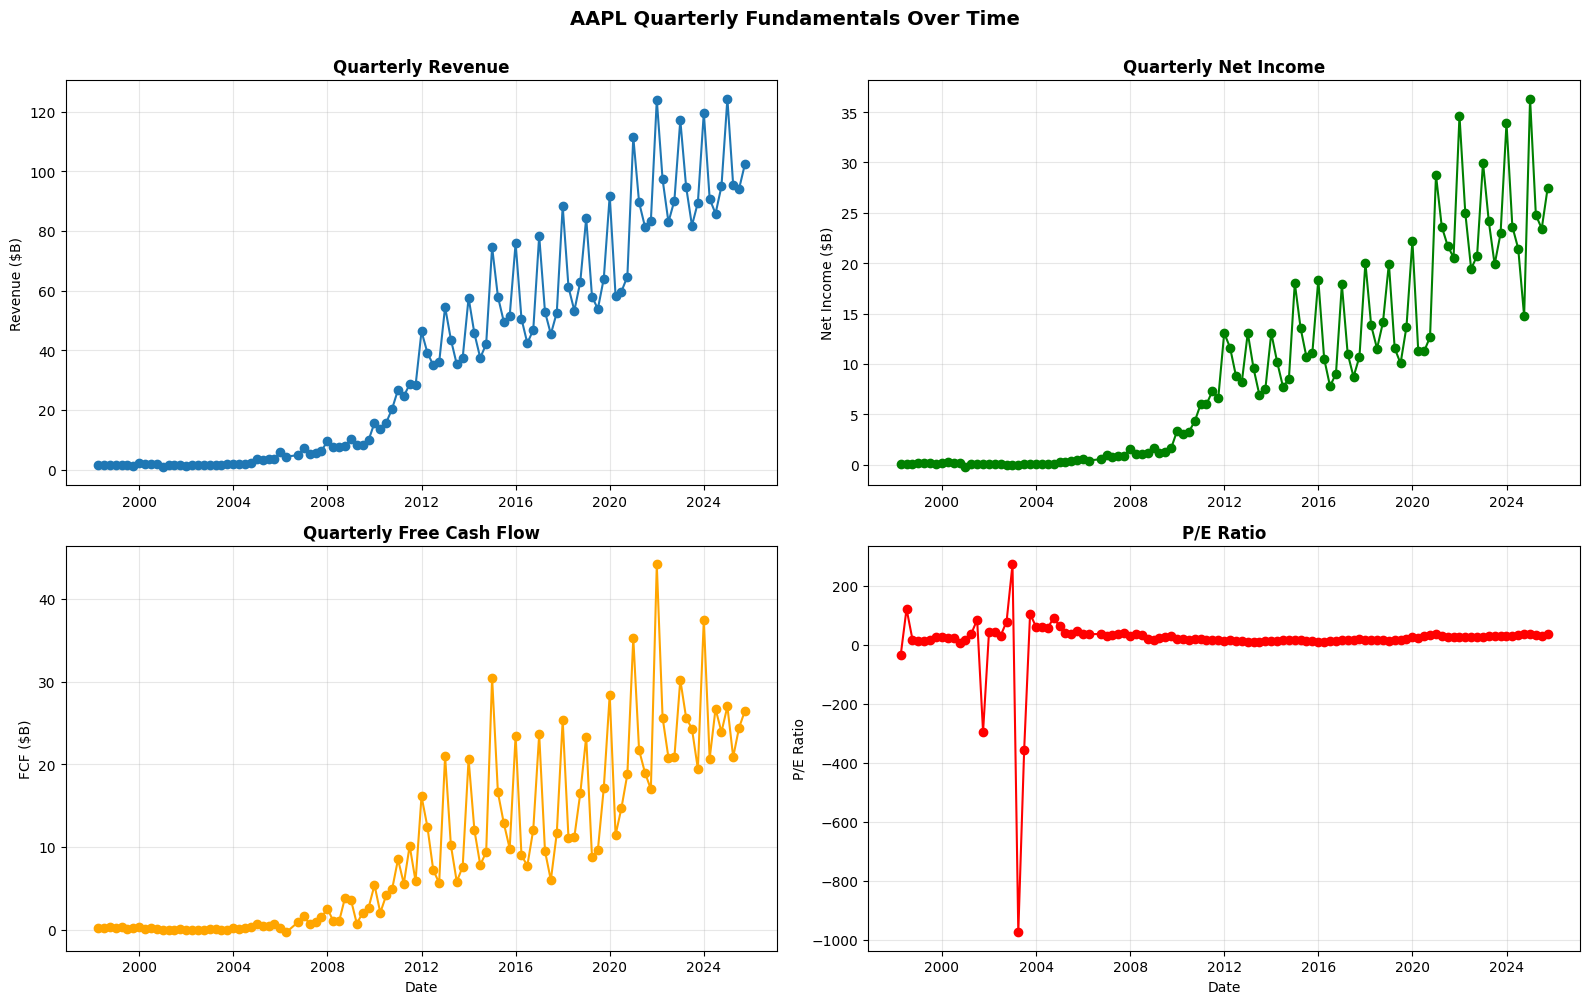

In [10]:
if FUNDAMENTALS_AVAILABLE and aapl_fund is not None:
    # Filter for As Reported Quarterly (ARQ) - this is what the data contains
    aapl_quarterly = aapl_fund[aapl_fund['dimension'] == 'ARQ'].copy()
    
    if len(aapl_quarterly) == 0:
        print("⚠️  No ARQ data found. Available dimensions:", aapl_fund['dimension'].unique())
    else:
        # Plot key metrics over time
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # Revenue
        axes[0, 0].plot(aapl_quarterly['calendardate'], aapl_quarterly['revenue'] / 1e9, marker='o')
        axes[0, 0].set_title('Quarterly Revenue', fontsize=12, fontweight='bold')
        axes[0, 0].set_ylabel('Revenue ($B)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Net Income
        axes[0, 1].plot(aapl_quarterly['calendardate'], aapl_quarterly['netinc'] / 1e9, marker='o', color='green')
        axes[0, 1].set_title('Quarterly Net Income', fontsize=12, fontweight='bold')
        axes[0, 1].set_ylabel('Net Income ($B)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Free Cash Flow
        axes[1, 0].plot(aapl_quarterly['calendardate'], aapl_quarterly['fcf'] / 1e9, marker='o', color='orange')
        axes[1, 0].set_title('Quarterly Free Cash Flow', fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel('FCF ($B)')
        axes[1, 0].set_xlabel('Date')
        axes[1, 0].grid(True, alpha=0.3)
        
        # PE Ratio
        axes[1, 1].plot(aapl_quarterly['calendardate'], aapl_quarterly['pe'], marker='o', color='red')
        axes[1, 1].set_title('P/E Ratio', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylabel('P/E Ratio')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle('AAPL Quarterly Fundamentals Over Time', fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.show()

## 5. Field Availability Analysis

Check which fundamental fields have data.

In [11]:
if FUNDAMENTALS_AVAILABLE:
    print("Analyzing field availability...\n")
    print("="*80)
    print("FIELD AVAILABILITY")
    print("="*80)
    
    availability = []
    
    for col in sf1.columns:
        if col in ['ticker', 'dimension', 'calendardate', 'datekey', 'reportperiod', 'fiscalperiod', 'lastupdated', 'sid', 'sharefactor', 'permaticker']:
            continue
        
        non_null = sf1[col].notna().sum()
        pct = non_null / len(sf1) * 100
        availability.append((col, non_null, pct))
    
    # Sort by availability
    availability.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\n{'Field':<30} {'Non-null':<15} {'Availability':>12}")
    print("-"*80)
    
    # Show top 40 fields
    for col, non_null, pct in availability[:40]:
        print(f"{col:<30} {non_null:<15,} {pct:>11.1f}%")
    
    print(f"\n...and {len(availability) - 40} more fields")

Analyzing field availability...

FIELD AVAILABILITY

Field                          Non-null        Availability
--------------------------------------------------------------------------------
dps                            635,441               100.0%
fxusd                          635,441               100.0%
debt                           635,239               100.0%
debtusd                        635,239               100.0%
payables                       635,239               100.0%
accoci                         635,233               100.0%
taxliabilities                 635,233               100.0%
deferredrev                    635,231               100.0%
deposits                       635,231               100.0%
cashneq                        635,220               100.0%
cashnequsd                     635,220               100.0%
equity                         635,196               100.0%
equityusd                      635,196               100.0%
shareswa                  

In [12]:
if FUNDAMENTALS_AVAILABLE:
    # Show fields with 0% availability (empty)
    empty_fields = [col for col, count, pct in availability if pct == 0]
    
    if empty_fields:
        print("\n" + "="*80)
        print("EMPTY FIELDS (0% availability)")
        print("="*80)
        for field in empty_fields:
            print(f"  - {field}")
    else:
        print("\n✓ No empty fields found!")


EMPTY FIELDS (0% availability)
  - assetsavg
  - assetturnover
  - equityavg
  - invcapavg
  - roa
  - roe
  - roic
  - ros


## 6. Compare Multiple Symbols

Compare fundamentals across multiple companies.

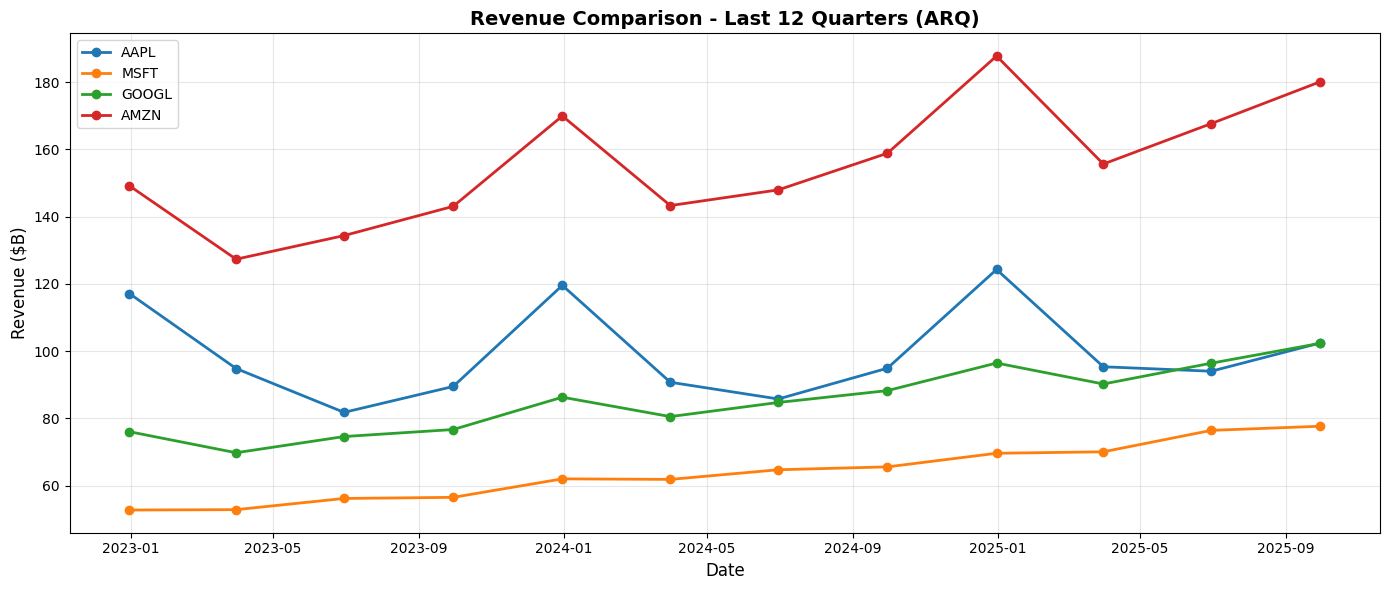

In [13]:
if FUNDAMENTALS_AVAILABLE:
    def compare_fundamentals(symbols, field='revenue', dimension='ARQ', recent_quarters=8):
        """Compare a fundamental metric across multiple symbols."""
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        for symbol in symbols:
            try:
                asset = bundle_data.asset_finder.lookup_symbol(symbol, as_of_date=None)
                data = sf1[(sf1['sid'] == asset.sid) & (sf1['dimension'] == dimension)].copy()
                
                if len(data) == 0:
                    print(f"⚠️  No data for {symbol}")
                    continue
                
                data['calendardate'] = pd.to_datetime(data['calendardate'])
                data = data.sort_values('calendardate').tail(recent_quarters)
                
                # Plot
                ax.plot(data['calendardate'], data[field] / 1e9, marker='o', label=symbol, linewidth=2)
                
            except Exception as e:
                print(f"❌ Error for {symbol}: {e}")
        
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel(f'{field.title()} ($B)', fontsize=12)
        ax.set_title(f'{field.title()} Comparison - Last {recent_quarters} Quarters ({dimension})', fontsize=14, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Compare revenue for tech giants
    compare_fundamentals(['AAPL', 'MSFT', 'GOOGL', 'AMZN'], field='revenue', recent_quarters=12)

## 7. Custom Queries

Run your own custom queries on the data.

In [14]:
# Example: Find stocks with highest FCF
if FUNDAMENTALS_AVAILABLE:
    # Get most recent quarter for each stock - using ARQ dimension
    latest = sf1[sf1['dimension'] == 'ARQ'].copy()
    latest['calendardate'] = pd.to_datetime(latest['calendardate'])
    
    # Get the latest date for each ticker
    latest_by_ticker = latest.sort_values('calendardate').groupby('ticker').tail(1)
    
    # Filter for stocks with positive FCF and reasonable PE
    quality = latest_by_ticker[
        (latest_by_ticker['fcf'] > 0) &
        (latest_by_ticker['pe'] > 0) &
        (latest_by_ticker['pe'] < 50)
    ].copy()
    
    if len(quality) > 0:
        # Sort by FCF
        top_fcf = quality.nlargest(20, 'fcf')
        
        print("\n" + "="*80)
        print("TOP 20 STOCKS BY FREE CASH FLOW (Most Recent Quarter)")
        print("="*80)
        print(f"\n{'Ticker':<10} {'FCF ($B)':<12} {'Revenue ($B)':<12} {'P/E':<8} {'Date':<12}")
        print("-"*80)
        
        for _, row in top_fcf.iterrows():
            print(f"{row['ticker']:<10} {row['fcf']/1e9:<12.2f} {row['revenue']/1e9:<12.2f} {row['pe']:<8.2f} {row['calendardate'].date()}")


TOP 20 STOCKS BY FREE CASH FLOW (Most Recent Quarter)

Ticker     FCF ($B)     Revenue ($B) P/E      Date        
--------------------------------------------------------------------------------
SKM        1084.87      4338.76      11.46    2025-06-30
SONY       295.21       3107.91      26.11    2025-09-30
TM         221.94       12377.43     8.51     2025-09-30
HMC        184.32       5292.41      8.93     2025-09-30
PTRCY      163.33       835.25       4.86     2022-06-30
TSM        139.43       989.92       28.81    2025-09-30
BAC        46.87        28.09        13.81    2025-09-30
NVO        32.48        74.98        13.47    2025-09-30
RY         28.47        16.98        14.71    2025-06-30
AAPL       26.49        102.47       35.67    2025-09-30
MSFT       25.66        77.67        38.37    2025-09-30
GOOGL      24.46        102.35       27.34    2025-09-30
PDD        21.64        103.98       13.13    2025-06-30
BABA       20.67        247.65       15.17    2025-06-30
CAJPY 

## 8. Export Data

Export data to CSV for external analysis.

In [15]:
# Example: Export AAPL price data
if aapl_prices is not None:
    output_file = 'aapl_prices_2023.csv'
    aapl_prices.to_csv(output_file)
    print(f"✓ Exported AAPL price data to {output_file}")

# Example: Export AAPL fundamentals
if FUNDAMENTALS_AVAILABLE and aapl_fund is not None:
    output_file = 'aapl_fundamentals.csv'
    aapl_fund.to_csv(output_file, index=False)
    print(f"✓ Exported AAPL fundamentals to {output_file}")

✓ Exported AAPL price data to aapl_prices_2023.csv
✓ Exported AAPL fundamentals to aapl_fundamentals.csv


## Summary

This notebook provides tools to:
- ✓ Browse available symbols and their SIDs
- ✓ Explore price history (OHLCV)
- ✓ Analyze fundamentals data (if available)
- ✓ Check field availability
- ✓ Compare metrics across companies
- ✓ Export data for further analysis

**Next Steps:**
1. Modify the `symbols` list to explore different companies
2. Change `field` parameter to explore different metrics
3. Adjust date ranges to focus on specific time periods
4. Create custom queries to find interesting stocks